In [1]:
#Starting sparksession
from pyspark.sql import SparkSession
from pyspark.sql.functions import dayofweek, col , when 
from pyspark.sql.functions import month, avg , max, min
import matplotlib.pyplot as plt
import seaborn as sns

#initialize the spark Session
spark = SparkSession.builder.appName("FlightAnalysis").config("spark.sql.debug.maxToStringFields", 1000).getOrCreate()

#Loading the data:
path = r"flight_data_with_headers.csv"
cleaned_df = spark.read.csv(path, inferSchema = True , header = True)

# Print the schema and RowCount in Data Frame
cleaned_df.printSchema()
cleaned_df.show(1)

#Extracting day of the week
cleaned_df = cleaned_df.withColumn("day_of_week", dayofweek(col("fl_date")))
cleaned_df.show(1)

# Identify if departure delays are more common during specific months
monthly_delay_stats = cleaned_df.groupBy(month("fl_date").alias("month")).agg(avg("dep_delay").alias("average_delay"))
monthly_delay_stats.show(1)

#Removing Nuls from all columns
cleaned_Null_Removed_df = cleaned_df.na.drop()
cleaned_Null_Removed_df.show(1)

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = tru

In [2]:
#Deriving New column from existing columns 
Flight_Data_Analysis_df = cleaned_Null_Removed_df.withColumn("total_delay", col("dep_delay") + col("arr_delay"))
Flight_Data_Analysis_df.show(1)

# Aggregations:

#Calculate average delays per airline :

agg_by_airline = Flight_Data_Analysis_df.groupBy("airline_code").agg(
    avg("dep_delay").alias("avg_dep_delay"),
    avg("arr_delay").alias("avg_arr_delay"),
    avg("total_delay").alias("avg_total_delay")
)
agg_by_airline.show(1)


#Find the maximum and minimum total delay per airline

agg_max_min_delay = Flight_Data_Analysis_df.groupBy("airline_code").agg(
    max("total_delay").alias("max_total_delay"),
    min("total_delay").alias("min_total_delay")
)

agg_max_min_delay.show(1)

+----------+------------+--------+---------+------+------------------+----+--------------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+-------+--------+------+-----------+-----------+
|   FL_DATE|AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|       ORIGIN_CITY|DEST|     DEST_CITY|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|DELAY_DUE_CARRIER|DELAY_DUE_WEATHER|DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|FL_YEAR|FL_MONTH|FL_DAY|day_of_week|total_delay|
+----------+------------+--------+---------+------+------------------+----+--------------+------------+--------+---------+--------+----------+---------+-------+--

In [3]:

#Calculate the average delay for each type of delay

avg_delay_by_type = Flight_Data_Analysis_df.groupBy().agg(
    avg("DELAY_DUE_CARRIER").alias("avg_carrier_delay"),
    avg("DELAY_DUE_WEATHER").alias("avg_weather_delay"),
    avg("DELAY_DUE_NAS").alias("avg_nas_delay"),
    avg("DELAY_DUE_SECURITY").alias("avg_security_delay"),
    avg("DELAY_DUE_LATE_AIRCRAFT").alias("avg_late_aircraft_delay")
)

avg_delay_by_type.show(1)


#Finding top 5 routes with the highest average delay

top_routes_with_highest_avg_delay = Flight_Data_Analysis_df.groupBy("ORIGIN", "DEST").agg(
    avg("DEP_DELAY").alias("avg_departure_delay")
).orderBy(col("avg_departure_delay").desc()).limit(5)

top_routes_with_highest_avg_delay.show(1)

+------------------+------------------+-----------------+-------------------+-----------------------+
| avg_carrier_delay| avg_weather_delay|    avg_nas_delay| avg_security_delay|avg_late_aircraft_delay|
+------------------+------------------+-----------------+-------------------+-----------------------+
|26.919171043945003|4.5331708123377386|11.01628575189715|0.22368906823605333|     23.239829323261386|
+------------------+------------------+-----------------+-------------------+-----------------------+

+------+----+-------------------+
|ORIGIN|DEST|avg_departure_delay|
+------+----+-------------------+
|   MTJ| LGA|              687.0|
+------+----+-------------------+
only showing top 1 row



In [4]:
# Transformations
#Create a new column for the average delay per flight

df_transformed = Flight_Data_Analysis_df.withColumn("avg_delay_per_flight", col("total_delay") / col("fl_day"))


#Extract hour from crs_dep_time

df_transformed = df_transformed.withColumn("dep_hour", (col("crs_dep_time") / 100).cast("int"))
df_transformed.show(1)


# Calculate the average delay for each day of the week
df_with_day_of_week = df_transformed.withColumn("DAY_OF_WEEK", dayofweek("FL_DATE"))
avg_delay_by_day_of_week = df_with_day_of_week.groupBy("DAY_OF_WEEK").agg(avg("DEP_DELAY").alias("avg_departure_delay")
).orderBy("DAY_OF_WEEK")
avg_delay_by_day_of_week.show(1)


# Statistical Analysis
#Calculate descriptive statistics for total_delay

stats_total_delay = df_transformed.agg(
    avg("total_delay").alias("mean_total_delay"),
    max("total_delay").alias("max_total_delay"),
    min("total_delay").alias("min_total_delay")
)
stats_total_delay.show(1)

+----------+------------+--------+---------+------+------------------+----+--------------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+-------+--------+------+-----------+-----------+--------------------+--------+
|   FL_DATE|AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|       ORIGIN_CITY|DEST|     DEST_CITY|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|DELAY_DUE_CARRIER|DELAY_DUE_WEATHER|DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|FL_YEAR|FL_MONTH|FL_DAY|day_of_week|total_delay|avg_delay_per_flight|dep_hour|
+----------+------------+--------+---------+------+------------------+----+--------------+------------

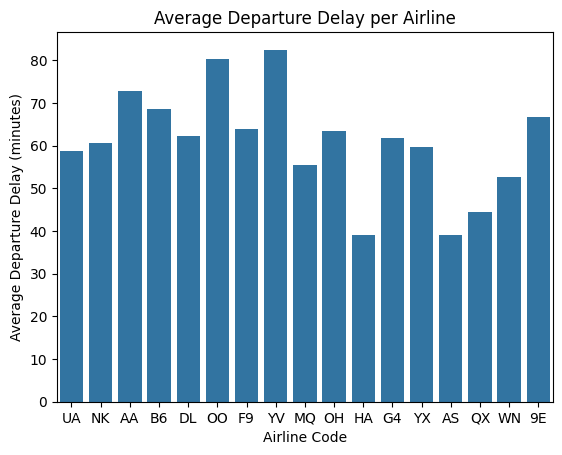

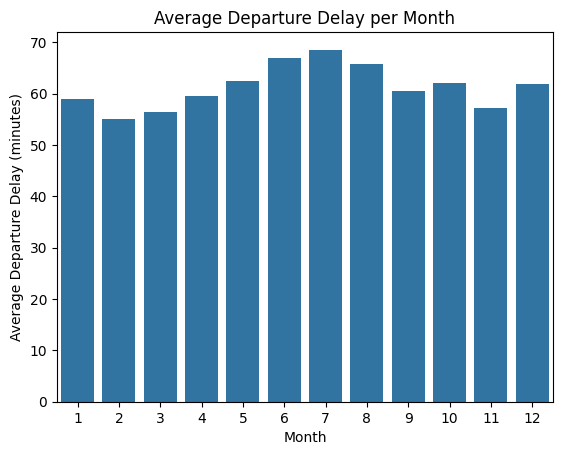

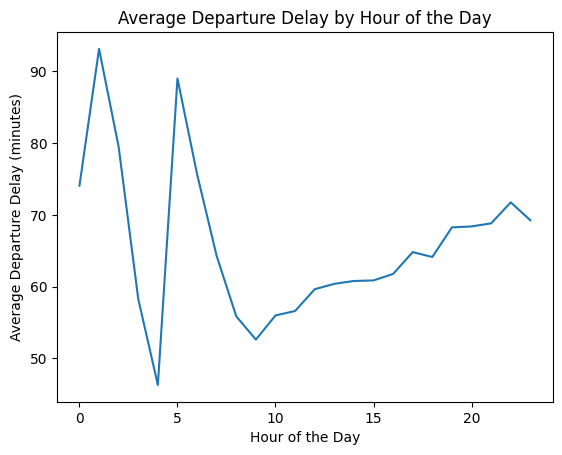

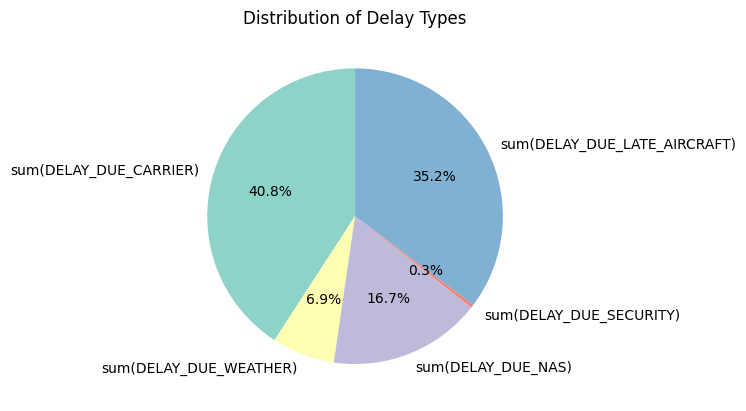

In [7]:
#Visualizing data using Plots:
#Using Matplotlib and Seaborn to create visualizations for research questions


# Average delay per airline.

avg_delay_by_airline = Flight_Data_Analysis_df.groupBy("AIRLINE_CODE").avg("DEP_DELAY").toPandas()
sns.barplot(x="AIRLINE_CODE", y="avg(DEP_DELAY)", data=avg_delay_by_airline)
plt.title("Average Departure Delay per Airline")
plt.xlabel("Airline Code")
plt.ylabel("Average Departure Delay (minutes)")
plt.show()



# How does departure delay vary across different months

avg_delay_by_month = Flight_Data_Analysis_df.groupBy("FL_MONTH").avg("DEP_DELAY").toPandas()
sns.barplot(x="FL_MONTH", y="avg(DEP_DELAY)", data=avg_delay_by_month)
plt.title("Average Departure Delay per Month")
plt.xlabel("Month")
plt.ylabel("Average Departure Delay (minutes)")
plt.show()



#Are there specific hours during the day when delays are more common

Flight_Data_Analysis_df = Flight_Data_Analysis_df.withColumn("DEP_HOUR", (Flight_Data_Analysis_df["CRS_DEP_TIME"] / 100).cast("int"))
avg_delay_by_hour = Flight_Data_Analysis_df.groupBy("DEP_HOUR").avg("DEP_DELAY").toPandas()
sns.lineplot(x="DEP_HOUR", y="avg(DEP_DELAY)", data=avg_delay_by_hour)
plt.title("Average Departure Delay by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Departure Delay (minutes)")
plt.show()


#What is the distribution of delays due to different reasons
delay_columns = ["DELAY_DUE_CARRIER", "DELAY_DUE_WEATHER", "DELAY_DUE_NAS", "DELAY_DUE_SECURITY", "DELAY_DUE_LATE_AIRCRAFT"]

delay_sums = Flight_Data_Analysis_df.select((delay_columns)).groupBy().sum().collect()[0].asDict()
labels = delay_sums.keys()
sizes = delay_sums.values()
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90, colors=sns.color_palette("Set3"))
plt.title("Distribution of Delay Types")
plt.show()